# 필요한 라이브러리 import

In [15]:
import os
import torch
import random
import cv2
import torchvision
from torch.utils.data import Dataset

import datasets
import transforms
import glob
from torch import nn, optim
import torch.nn.functional as F
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# GPU Setting

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'device:{device}')

device:cuda


# Hyperparameter Setting

In [3]:
# training
num_epochs = 50
lr = 1e-4
# lr = 1e-6 for late fusion 3d cnn network
batch_size = 10
seed = 2022

# Seed 설정

In [4]:
def seed_everything(seed: int = 42, contain_cuda: bool = False):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    print(f"Seed set as {seed}")

In [5]:
seed_everything(seed=2022)

Seed set as 2022


# Sporting Events Dataset to Tensor

In [6]:
train_video = datasets.VideoLabelDataset(
            "/root/2022-2-deeplearning-final/train_video.csv",
        transform=torchvision.transforms.Compose([
            transforms.VideoFilePathToTensor(max_len=30, fps=10, padding_mode='last'),
            transforms.VideoResize([64, 64]),
        ])
)

test_video = datasets.VideoLabelDataset(
            "/root/2022-2-deeplearning-final/test_video.csv",
        transform=torchvision.transforms.Compose([
            transforms.VideoFilePathToTensor(max_len=30, fps=10, padding_mode='last'),
            transforms.VideoResize([64, 64]),
        ])
)
train_loader = torch.utils.data.DataLoader(train_video, batch_size=batch_size , shuffle=True)
test_loader = torch.utils.data.DataLoader(test_video, batch_size=batch_size , shuffle=False)

print(f'train: {len(train_loader.dataset)}')
print(f'train_loader: {len(train_loader)}')

print(f'test: {len(test_loader.dataset)}')
print(f'test_loader: {len(test_loader)}')


# train set 데이터 확인하기
images, labels = next(iter(train_loader))
test, labels_test = next(iter(test_loader))
print(images.shape, labels.shape)
print(test.shape, labels_test.shape)

train: 600
train_loader: 60
test: 150
test_loader: 15


/usr/local/lib/python3.7/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


torch.Size([10, 3, 30, 64, 64]) torch.Size([10])
torch.Size([10, 3, 30, 64, 64]) torch.Size([10])


# HyperParameters for CNN+GRU Model and Late_Fusion 3D convolution model

In [7]:
hidden_size = 256
num_layers = 1
input_size = 128 * 6 * 6
num_classes = 10

# Model 정의(CNN과 GRU(LSTM)를 혼합한 모델)

In [8]:
class CNN_GRU(nn.Module):
    def __init__(self, batch_size, hidden_size, input_size, num_layers, num_class):
        super(CNN_GRU, self).__init__()
        # First, process CNN to extract features from each image
        self.layer1 = nn.Sequential(
            nn.Conv3d(in_channels=3, out_channels=32, kernel_size= (1, 3, 3) , padding=(0, 1, 1)),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride = (1, 2, 2)))
        self.layer2 = nn.Sequential(
            nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(1, 3, 3)),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride = (1, 2, 2)))
        self.layer3 = nn.Sequential(nn.Conv3d(in_channels=64, out_channels=128, kernel_size= (1, 4, 4)),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride = (1, 2, 2)))
        
        # process the recurrent neural network algorithm
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first = True)
        self.fully_connected_layer = nn.Linear(hidden_size, num_classes)
    
    def forward(self, image):
        out = self.layer1(image)
        out2 = self.layer2(out)
        out3 = self.layer3(out2)
        
        result_of_CNN = out3.reshape(out3.size(0), out3.shape[2], -1)
        # 이부분이 살짝 헷갈려서 체크해주세요!!
        initial_hidden_state = torch.zeros(self.num_layers, result_of_CNN.size(0), self.hidden_size).to(device)
        
        
        # use this code below when we are implementing LSTM
        # initial_cell_state = torch.zeros(self.num_layers, result_of_CNN.size(0), self.hidden_size).to(device)
        self.gru.flatten_parameters()
        output, _ = self.gru(result_of_CNN, initial_hidden_state)
        
        return self.fully_connected_layer(output[:,-1,:])
        

# 제2 모델 정의(Late Fuse 3d convolution을 이용한 비디오 classification)

In [9]:
class Video_Recognition_Convolution(nn.Module):
    def __init__(self, num_class):
        super(Video_Recognition_Convolution, self).__init__()
        
         # First, process CNN to extract features from each image
        self.layer1 = nn.Sequential(
            nn.Conv3d(in_channels=3, out_channels=64, kernel_size= (7, 3, 3) , padding=(0, 1, 1)),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride = (2, 2, 2)))
        self.layer2 = nn.Sequential(
            nn.Conv3d(in_channels=64, out_channels=128, kernel_size=(5, 3, 3)),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride = (2, 2, 2)))
        self.layer3 = nn.Sequential(nn.Conv3d(in_channels=128, out_channels=256, kernel_size= (3, 4, 4)),
            nn.BatchNorm3d(256),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride = (2, 2, 2)))
        
        self.flatten_1 = nn.Linear(256 * 6 * 6, 256 * 6)
        self.flatten_2 = nn.Linear(256 * 6, 256)
        self.flatten_3 = nn.Linear(256, num_class)
        
        self.relu = nn.ReLU()
        
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, frame):
        frame1 = self.layer1(frame)
        frame2 = self.layer2(frame1)
        frame3 = self.layer3(frame2)
        
        Conv_Output = frame3.reshape(frame3.shape[0], -1)
        
        flat_frame1 = self.flatten_1(Conv_Output)
        flate_frame1 = self.relu(flat_frame1)
        flat_frame2 = self.flatten_2(flat_frame1)
        flat_frame2 = self.relu(flat_frame2)
        flat_frame3 = self.flatten_3(flat_frame2)
        flat_frame3 = self.relu(flat_frame3)
        final_output = self.dropout(flat_frame3)
        
        return final_output

# Xavier initialization

In [9]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# Model, Optimizer, Scheduler setting

In [10]:
model = CNN_GRU(batch_size, hidden_size, input_size, num_layers, num_classes).to(device)
#model = Video_Recognition_Convolution(num_classes).to(device)
model.apply(init_weights)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.95 ** epoch, last_epoch=-1, verbose=False)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.5)

# Loss, accuracy 저장을 위한 세팅

In [11]:
running_loss_history = []
running_corrects_history = []
test_running_loss_history = []
test_running_corrects_history = []
lr_running_history = []
average_accuracy_of_class_epoch = []
num_epochs_class = []

# class-wise-test-accuracy

In [12]:
def Check_Accuracy(image_prediction, test_target, correct_list, incorrect_list):
    num_samples_batch = len(image_prediction)
    for i in range(0, num_samples_batch):
        class_index = image_prediction[i]
        if image_prediction[i] == test_target[i]:
            correct_list[class_index] = correct_list[class_index] + 1
        else:
            incorrect_list[class_index] = incorrect_list[class_index] + 1
            
    return correct_list, incorrect_list

In [13]:
def Get_Average(correct_list, incorrect_list, num_class):
    answer = 0
    for i in range(0, num_class):
        if correct_list[i] + incorrect_list[i] != 0:
            answer = answer + (correct_list[i]/ (correct_list[i] + incorrect_list[i]))
        
    answer = answer / num_class
    
    return answer

# 학습 및 각 epoch에 대한 train/test loss, accuracy 출력

In [14]:
x = 0
for epoch in tqdm(range(num_epochs), desc = 'epoch'):
    running_loss, test_running_loss = 0.0, 0.0
    running_corrects, test_running_corrects = 0.0, 0.0
    
    correct_class_prediction = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    incorrect_class_prediction = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    
    # process of getting x values for average accuracy for class for each epoch
    x = x + 1
    num_epochs_class.append(x)
    
    model.train()    
    for inputs, labels in tqdm(train_loader, desc = 'train'):
        inputs, labels = inputs.to(device), labels.to(device)
        # feedforward
        outputs = model(inputs)
        # loss를 계산
        loss = loss_func(outputs, labels)
        # gradient 초기화
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        # weight update
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss/len(train_loader)
    running_loss_history.append(epoch_loss)
    
    epoch_acc = running_corrects/len(train_loader.dataset)
    running_corrects_history.append(epoch_acc)
    
    print('training loss : {:4f}, acc : {:4f},'.format(epoch_loss, epoch_acc))
    with torch.no_grad():
        model.eval()
        for test_inputs, test_labels in tqdm(test_loader, desc = 'test'):
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
            test_outputs = model(test_inputs)
            test_loss = loss_func(test_outputs, test_labels)
            
            _, test_preds = torch.max(test_outputs, 1)
            
            test_running_loss += test_loss.item()
            test_running_corrects += torch.sum(test_preds==test_labels.data)
            
            correct_class_prediction, incorrect_class_prediction = Check_Accuracy(test_preds, test_labels, correct_class_prediction, incorrect_class_prediction)
    
    mean = Get_Average(correct_class_prediction, incorrect_class_prediction, 10)
    average_accuracy_of_class_epoch.append(mean)
    
    test_epoch_loss = test_running_loss / len(test_loader)
    test_running_loss_history.append(test_epoch_loss)
    
    test_epoch_acc = test_running_corrects / len(test_loader.dataset)
    test_running_corrects_history.append(test_epoch_acc)
    

    
    print('test loss : {:4f}, acc : {:4f}'.format(test_epoch_loss, test_epoch_acc))
    scheduler.step()
    lr_running_history.append(scheduler.get_last_lr())
    print(f'learning rate : { scheduler.get_last_lr() }')

epoch:   0%|          | 0/50 [00:15<?, ?it/s]


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/torch/nn/parallel/parallel_apply.py", line 61, in _worker
    output = module(*input, **kwargs)
  File "/usr/local/lib/python3.7/site-packages/torch/nn/modules/module.py", line 889, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/tmp/ipykernel_217/3804200486.py", line 38, in forward
    output, _ = self.gru(result_of_CNN, initial_hidden_state)
  File "/usr/local/lib/python3.7/site-packages/torch/nn/modules/module.py", line 889, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/usr/local/lib/python3.7/site-packages/torch/nn/modules/rnn.py", line 819, in forward
    self.check_forward_args(input, hx, batch_sizes)
  File "/usr/local/lib/python3.7/site-packages/torch/nn/modules/rnn.py", line 226, in check_forward_args
    self.check_input(input, batch_sizes)
  File "/usr/local/lib/python3.7/site-packages/torch/nn/modules/rnn.py", line 204, in check_input
    self.input_size, input.size(-1)))
RuntimeError: input.size(-1) must be equal to input_size. Expected 18432, got 4608


# Loss 그래프(train, test)

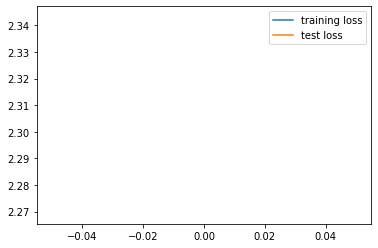

In [33]:
plt.plot(running_loss_history, label='training loss')
plt.plot(test_running_loss_history, label='test loss')
plt.legend()

# Accuracy 그래프(train, test)

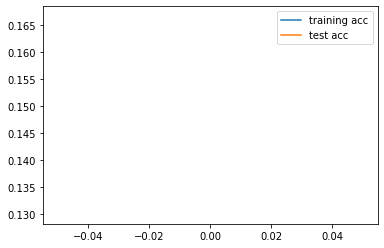

In [34]:
plt.plot(running_corrects_history, label='training acc')
plt.plot(test_running_corrects_history, label='test acc')
plt.legend()

# lr 그래프

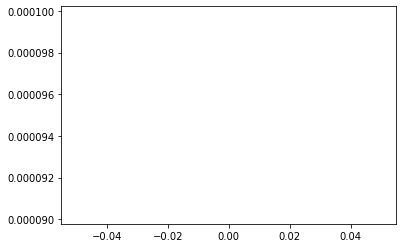

In [35]:
plt.plot(lr_running_history, label='learning rate')

# test set에 대한 class 별 accuracy

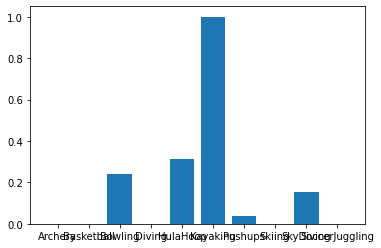

In [36]:
list_of_sporting_events_class = ['Archery','Basketball','Bowling','Diving','HulaHoop','Kayaking',
                        'Pushups','Skiing','SkyDiving','SoccerJuggling']

final_class_accuracy_list = []

for i in range(0, 10):
    if correct_class_prediction[i] + incorrect_class_prediction[i] != 0:
        acc = correct_class_prediction[i] / (correct_class_prediction[i] + incorrect_class_prediction[i])
        final_class_accuracy_list.append(acc)
    else:
        final_class_accuracy_list.append(0)

# show the accuracy graph of each kimchi class obtained through CNN model
interval = np.arange(10)
plt.xticks(interval, list_of_sporting_events_class)
plt.bar(interval, final_class_accuracy_list)
plt.show()

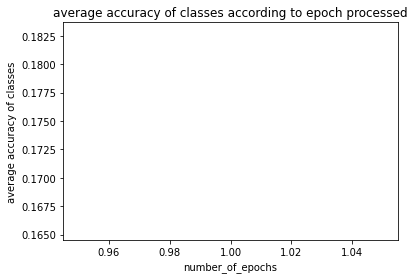

In [37]:
plt.plot(num_epochs_class, average_accuracy_of_class_epoch)
plt.xlabel("number_of_epochs")
plt.ylabel("average accuracy of classes")
plt.title("average accuracy of classes according to epoch processed")
plt.show()